<a href="https://colab.research.google.com/github/Bobr48/seq2seq_attention_mechanism/blob/main/Copy_of_37_4_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**
1. [Механизм внимания](https://colab.research.google.com/drive/1VWigPMuZVLXJa7Ys-WCSKAZcg4ZUhjny)
2. [Англо-русский переводчик c механизмом внимания](https://colab.research.google.com/drive/1iqWK_AfEG3GtruW9RN_PthHvn04QSbhg)
3. [Переводчик с нейро-сетевым механизмом внимания](https://colab.research.google.com/drive/1kXBDTWUCoiXFSpOaE2562X5n92Ehdpfg)
4. Домашняя работа

В домашней работе вам необходимо выполнить одно из трёх заданий на выбор:

**Задание 1. На 3 балла:**

1. Используя любой публичный датасет с диалогами, создайте чат-бот seq2seq с механизмом внимания. Задача обучить сеть по входной последовательности вопросов генерировать ответы.

2. Отобразите график внимания.

3. Если возникнет проблема с поиском датасета с диалогами, то можно использовать этот: https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt

**Задание 2. На 4 балла:**

Необходимо выполнить 1 задание со следующими изменениями:
1. Разработать класс внимания, который будет включать механизм внимания Богданова и 3 варианта механизма внимания Luong:

$$
f(h_{t-1}, e_{t'}) =
\begin{cases}
h_{t-1}^T e_{t'} & \text{точечное внимание}\\
h_{t-1}^T W e_{t'} & \text{общее внимание}\\
v^T \tanh \left(W [h_{t-1}, e_{t'}]\right) & \text{объединенное внимание}\\
\end{cases}
$$

Выбор используемого механизма внимания должен происходить при инициализации класса.

In [1]:
# Модуль линейной алгебры
import numpy as np

# Генератор случайного числа
from random import randint

# Работа с юникодом
import unicodedata

# Регулярные выражения
import re

# Модуль статистики pandas
import pandas as pd

# Низкоуровневые методы фреймворка
import tensorflow as tf

# Модели keras
from keras.models import Model, load_model

# Слои keras
from keras.layers import Dense, Embedding, GRU, Input, Dense, Embedding, Bidirectional, Concatenate, Dropout, Dot

# Оптимайзеры
from keras.optimizers import RMSprop, Adadelta, Adam

# Метод ограничения длины последовательности
from keras.preprocessing.sequence import pad_sequences

# Токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Утилиты keras
from keras import utils

# Коллбэки
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Визуализация графа модели
from keras.utils import plot_model

# Расщепление выборок
from sklearn.model_selection import train_test_split

# Работа с графиками
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Отключаем лишние предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
if not 'dialogs.txt' in os.listdir():
  !wget https://storage.yandexcloud.net/academy.ai/LLM/dialogs.txt


In [3]:
BATCH_SIZE = 128      # размер обучающего пакета.
EPOCHS = 20            # число эпох обучения.
MODE = 4              # 1 - внимания Богданова/ 2 - объединенное внимание/ 3 - общее внимание/ 4 или Всё кроме (1,2,3) - точечное внимание
UNITS  = 1024         # число нейронов в рекуррентных с слоях.
EMBED_DIM = 256       # размерность эмбеддинга.
NUM_SAMPLES = 3725   # число примеров для обучения.
FILE_NAME = "dialogs.txt" # имя файла со словарем в архиве
SOS = '<start>'       # токен начала последовательсти
EOS = '<end>'         # токен окончания последовательсти

In [4]:
df = pd.read_csv(FILE_NAME, sep='\t', header=None)
df.head()

,0,1
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


In [5]:
print(df.shape)
df[NUM_SAMPLES-5:NUM_SAMPLES]

(3725, 2)


,0,1
3720,that's a good question. maybe it's not old age.,are you right-handed?
3721,are you right-handed?,yes. all my life.
3722,yes. all my life.,you're wearing out your right hand. stop using...
3723,you're wearing out your right hand. stop using...,but i do all my writing with my right hand.
3724,but i do all my writing with my right hand.,start typing instead. that way your left hand ...


In [6]:
def preprocess_sentence(w):
    w = re.sub(r"([?.!,;:¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?'`.!,;:¿]+", " ", w)
    w = w.rstrip().strip()

    # Добавляем в фразу токены SOS и EOS
    w = SOS + ' ' + w + ' ' + EOS
    return w

In [7]:
# Собираем вопросы и ответы в списки

questions = [] # список входных фраз
answers = []   # список ответных фраз

with open(FILE_NAME, "r", encoding="utf-8") as f: # открываем файл в режиме чтения
    lines = f.read().split("\n")                    # считываем весь файл, разделяя на строки

for line in lines[: min(NUM_SAMPLES, len(lines) - 1)]:
    # Разделяем строку по табам (входные данные, выходные и ненужный столбец)
    input_text, target_text = line.split("\t")

    # Подготовка данных
    questions.append(preprocess_sentence(input_text))
    answers.append(preprocess_sentence(target_text))

print("Число примеров:", len(answers))

#  Получим случайный вопрос и ответ
random_index = randint(0, len(questions)-1)
print(f'Вопрос : {questions[random_index]}') # Пример входной фразы
print(f'Ответ : {answers[random_index]}')    # Пример ответной фразы

Число примеров: 3724
Вопрос : <start> really ? what kind of shoes are they ? <end>
Ответ : <start> these are called all star chuck taylors . <end>


In [8]:
def tokenize(text): # функция принимает текст на заданном языке
    # Создадим токенайзер
    tokenizer = Tokenizer(filters='')

    # Загружаем в токенизатор тексты для обработки и сборки словаря частотности
    tokenizer.fit_on_texts(text)

    # Векторизируем фразы
    seq = tokenizer.texts_to_sequences(text)

    # Делаем последовательности одной длины, заполняя нулями короткие фразы
    pseq = pad_sequences(seq, padding='post')

    # Возвращаем последовательность индексов и токенизатор
    return pseq, tokenizer

In [9]:
paddedQuestions, tokenizer_en = tokenize(questions)    # формируем вектор фикс длины для вопросов  и токенизатор для английского языка
paddedAnswers, tokenizer_ru   = tokenize(answers)      # формируем вектор фикс длины для ответов  и токенизатор для русского языка

In [10]:
max_length_ru = paddedAnswers.shape[1]
max_length_en = paddedQuestions.shape[1]

In [11]:
# Создание обучающей и проверочной выборок в соотношении 80/20
questions_train, questions_val, answers_train, answers_val = train_test_split(paddedQuestions, paddedAnswers, test_size=0.2)

In [12]:
# Определим параметры
BUFFER_SIZE = len(questions_train)                     # случайно сэмплировать будем по всей длине обучающейся выборки
STEPS_PER_EPOCH = len(questions_train)//BATCH_SIZE     # количество шагов в одной эпохе
VOCAB_EN_SIZE = len(tokenizer_en.word_index) + 1
VOCAB_RU_SIZE = len(tokenizer_ru.word_index) + 1

In [13]:
# Маппинг данных из индексов в слова
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Исходный язык:")
convert(tokenizer_en, questions_train[0])
print ()
print ("Целевой язык:")
convert(tokenizer_ru, answers_train[0])

Исходный язык:
1 ----> <start>
11 ----> it
393 ----> may
18 ----> have
102 ----> been
1044 ----> random
7 ----> ,
33 ----> but
18 ----> have
6 ----> you
4 ----> ?
2 ----> <end>

Целевой язык:
1 ----> <start>
4 ----> i
175 ----> haven't
442 ----> lately
3 ----> .
2 ----> <end>


In [14]:
# Создаём датасет
dataset = tf.data.Dataset.from_tensor_slices((questions_train, answers_train)).shuffle(BUFFER_SIZE)

# Передаем в датасет размер батча и указываем, что если в тренировке последний батч окажется неполным, то опустим его
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
# Посмотрим на форму примеров полученных батчей
example_questions_batch, example_answers_batch = next(iter(dataset))
print('Форма батчей ENG и RU: ', example_questions_batch.shape, example_answers_batch.shape)

Форма батчей ENG и RU:  (128, 24) (128, 24)


In [16]:
class Encoder(tf.keras.Model):

  # Конструктор класса
  def __init__(self,
               vocab_size,    # размер словаря
               embedding_dim, # размер пространства эмбеддинга
               enc_units,     # число нейронов в GRU
               batch_sz):     # размер батча

    super(Encoder, self).__init__()                                   # вызываем инициализацию родительского класса
    self.batch_sz = batch_sz                                          # инициализируем переменную размера батча внутри класса
    self.enc_units = enc_units                                        # инициализируем переменную размера слоя в кодировщике
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)             # инициализируем слой эмбеддинга с заданными параметрами

    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # инициализируем рекуррентный слой с заданными параметрами

  # Метод принимает входную фразу и начальное состояние
  def call(self,
           x,         # входная фраза
           hidden):   # начальное состояние



    x = self.embedding(x)   # входящие тензоры преобразовываются эмбеддингом
    temp = self.gru(x, initial_state = hidden) # далее пропускаем через слой GRU и получаем выходные данные и новое состояние
    print(len(temp))


    output, state = temp
    # Получаем форму output: (batch size, max_length, hidden_size)
    # Получаем форму state: (batch size, hidden_size)
    # sequence length == max_length
    # units == hidden_size
    return output, state # выход сети и состояние на выходе

  # Создаем метод инициализации состояний на скрытых слоях
  # Вернем тензор из нулей размер батча на размер слоя, его будем использовать как начальное состояние энкодера
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
# Создадим модель кодировщика по заданным параметрам
encoder = Encoder(VOCAB_EN_SIZE, EMBED_DIM, UNITS, BATCH_SIZE)

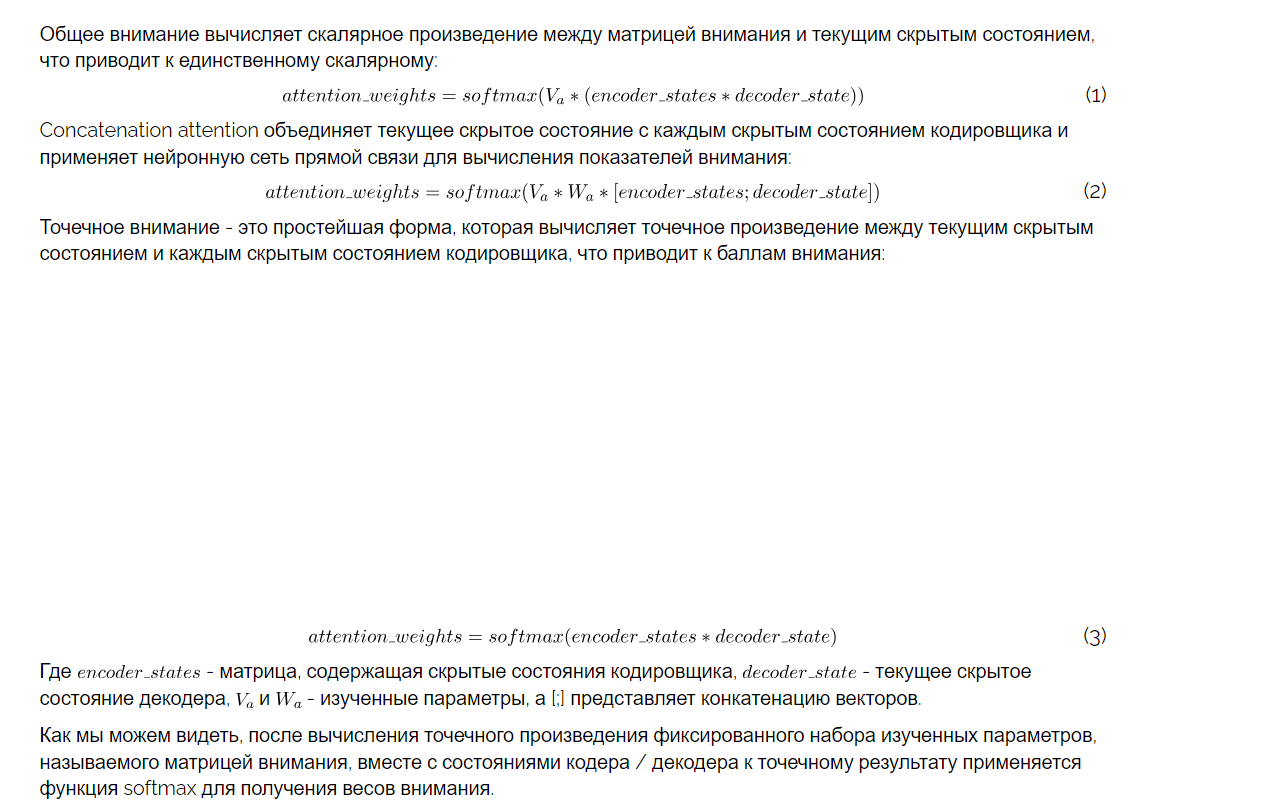

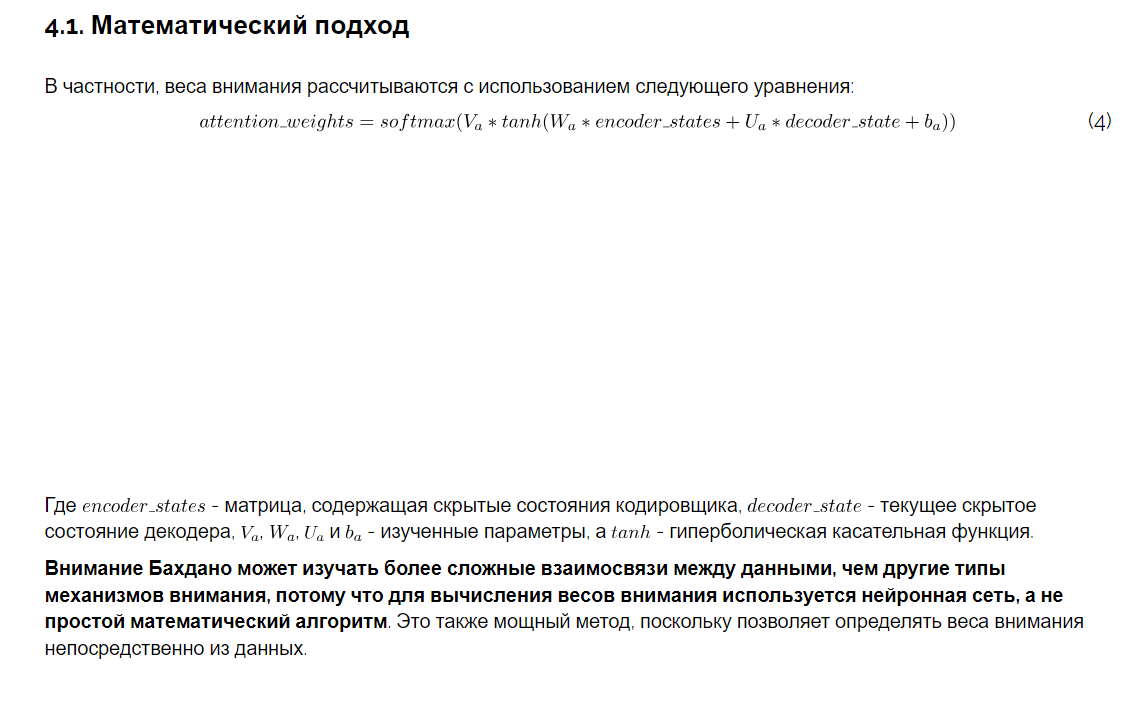

In [18]:
class Attention(Model): # Название класса именем создателя механизма Дмитрия Богданова(Bahdanau)

  # Создаем конструктор класса
  def __init__(self, case_n, units=10):                        # число нейронов
    self.case_n = case_n
    super(Attention, self).__init__() # вызываем инициализацию родительского класса
    self.W1 = Dense(units)                    # создаем Dense с заданным числом нейронов
    self.W2 = Dense(units)                    # создаем Dense с заданным числом нейронов
    self.V =  Dense(1)                        # создаем Dense с числом нейронов =1


  # Метод принимает скрытые состояния и выход кодировщика
  def call(self,
           hidden_state, # состояния кодировщика (часто обозначается как query)
           values):      # выход кодировщика
    match self.case_n:
      case 1:     #  внимания Богданова
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
      case 2:     # объединенное внимание
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])
        score = self.V(self.W1(tf.transpose(tf.matmul(hidden_with_time_axis, values_transposed), perm=[0, 2, 1])))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
      case 3:     # общее внимание
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])
        score = self.V(tf.transpose(tf.matmul(hidden_with_time_axis, values_transposed), perm=[0, 2, 1]))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
      case _:     # точечное внимание
        hidden_with_time_axis = tf.expand_dims(hidden_state, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])
        score = tf.transpose(tf.matmul(hidden_with_time_axis, values_transposed), perm=[0, 2, 1])
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1) # размеры вектора контекста после суммирования будут (batch_size, hidden_size)

    # Возвращает вектор контекста и веса внимания
    return context_vector, attention_weights


In [19]:
# Создадим экземпляр класса внимания
attention_layer = Attention(MODE)

In [20]:
class Decoder(Model):

  # Конструктор класса
  def __init__(self,
               vocab_size,    # размер словаря
               embedding_dim, # размерность пространства эмбеддинга
               dec_units,     # число нейронов в GRU
               batch_sz):     # размер батча
    super(Decoder, self).__init__()                       # вызываем инициализацию родительского класса
    self.batch_sz = batch_sz                              # инициализируем переменную размера батча внутри класса
    self.dec_units = dec_units                            # инициализируем переменную размера слоя в декодировщике
    self.embedding = Embedding(vocab_size, embedding_dim) # инициализируем слой эмбеддинга с заданными параметрами

    self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # инициализируем рекуррентный слой с заданными параметрами


    self.fc = Dense(vocab_size) # полносвязный слой с размером словаря

    self.attention = Attention(MODE) # механизм внимания


  def call(self,
           x,           # начальный токен входной последовательности
           hidden,      # состояние кодировщика
           enc_output # выход кодировщика
          ):

    # Форма x: (batch_size, 1)
    # Форма hidden: (batch_size, max_length)
    # Форма enc_output: (batch_size, max_length, hidden_size)

    # Форма context_vector: (batch_size, hidden_size)
    # Форма attention_weights: (batch_size, max_length, 1)

    context_vector, attention_weights = self.attention(hidden, enc_output)

    # Форма x после прохождения через  embedding: (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # Дальше конкатенируем с вектором контекста и получаем (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # Сконкатенированный вектор передаем  в GRU и получаем выход с декодера и состояние
    output, state = self.gru(x, initial_state = hidden)

    # Форма output: (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # Пропускаем через полносвязный слой
    x = self.fc(output)

    # Форма выходной фразы: (batch_size, vocab)
    # Вернем выходную фразу, вектор состояния, веса внимания
    return x, state, attention_weights

In [21]:
# Создали декодировщик с параметрами
decoder = Decoder(VOCAB_RU_SIZE, EMBED_DIM, UNITS, BATCH_SIZE)

In [22]:
# Оптимизатор Adam
optimizer = tf.keras.optimizers.Adam()

# Функция потерь
def loss_function(real, pred):

  # Не все последовательности имеют одинаковую длину.
  # Если в последовательности есть "0", то соответствующую ей потерю будем обнулять
  # Для этого создадим маску
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  # Создаем экземпляр класса SparseCategoricalCrossentropy
  # И сразу вызываем его метод call() с параметрами: истинная и предсказанная фраза
  # Получаем тензор ошибки
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype) # приводим тип маски к типу потерь
  loss *= mask                           # маскируем потери, избавляемся от заполняющих нулей

  return tf.reduce_mean(loss) # вернем среднее значение тензора

In [23]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [24]:
#@tf.function
def train_step(inp, targ, enc_hidden): # определим входную фразу, перевод и состояние кодировщика
  loss = 0 # переменная для фиксации ошибки

  # tf.GradientTape() - записывает все  операции по вычислению градиента на ленту (tape)
  with tf.GradientTape() as tape:

    # Передаем входную последовательность и начальное состояние кодировщика
    # Получим выход и состояние на выходе
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden используется вниманием, передадим состояние enc_hidden в декодер (фактически переименование для сохранения сути)
    dec_hidden = enc_hidden

    # SOS <start> токен инициализирует вход декодировщика
    dec_input = tf.expand_dims([tokenizer_ru.word_index[SOS]] * BATCH_SIZE, 1)

    # teacher forcing technique - ввод целевого токена (выходного слова) в качестве следующего входного токена
    for t in range(1, targ.shape[1]): # для каждого слова из фразы

      # Передаем enc_output в декодировщик
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # Вычисляем потери
      loss += loss_function(targ[:, t], predictions)

      # Используем teacher forcing (переход на следующий шаг)
      dec_input = tf.expand_dims(targ[:, t], 1)

  # Поскольку эта функция вызывается для каждого пакета, вычисляем значение batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Получаем переменные модели, для которых нужно считать градиенты
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Вычисляем градиенты
  gradients = tape.gradient(loss, variables)

  # Обновляем веса модели
  optimizer.apply_gradients(zip(gradients, variables))

  # Функция обучения возвращает значение ошибки на батче
  return batch_loss

In [ ]:
import time

# Цикл обучения
for epoch in range(EPOCHS):
  start = time.time()

  # Инициализация скрытого состояния
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # Цикл по всему датасету
  for (batch, (inp, targ)) in enumerate(dataset.take(STEPS_PER_EPOCH)):

    # Вызываем метод обучения
    batch_loss = train_step(inp, targ, enc_hidden)

    # Вычисляем потери по пакетам
    total_loss += batch_loss

  # Сохраняем чекпоинты каждые 5 эпох
  if (epoch + 1) % 5 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # статистика по каждой эпохе
  print(f'Эпоха: {epoch + 1}  |  Потеря:  {(total_loss / STEPS_PER_EPOCH):.4f}  |  Время на эпоху: {time.time() - start} сек \n' )

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [ ]:
import numpy as np

# Функция оценки - аналогична циклу обучения
def evaluate(sentence):

  # Предобработка фразы
  sentence = preprocess_sentence(sentence)

  # Приведем предложение к нижнему регистру и разобьем на слова
  words = sentence.split(' ')
  inputs = list() # список для сбора токенов

  # Для каждого слова в предложении найдем токен в словаре, если не найдем, то пропустим
  for word in words:

      try:
          inputs.append(tokenizer_en.word_index[word]) # находим индекс в словаре и добавляем в список
      except:
          pass # игнорируем слово, которое не знаем

  # Зафиксируем длину последовательности, дополнив нулями
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_en,
                                                         padding='post')
  # Конвертируем вход в тензор
  inputs = tf.convert_to_tensor(inputs)
  print(inputs)
  result = ''

  hidden = [tf.zeros((1, UNITS))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([tokenizer_ru.word_index[SOS]], 0)

  # Повторяйте цикл до тех пор, пока не будет достигнута максимальная длина для целевого языка
  for t in range(max_length_ru):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # Сохраняем значения коэффициентов внимания
    attention_weights = tf.reshape(attention_weights, (-1, ))

    # Получаем предсказание с максимальным вниманием
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Добавляем токены к результату
    result += tokenizer_ru.index_word[predicted_id] + ' '

    # Если токен <end> достигнут, возвращаем результат и входные данные
    if tokenizer_ru.index_word[predicted_id] == EOS:
      return result, sentence

    # Педсказанное значение подается обратно в модель
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [ ]:
# Функция перевода
def translate(sentence):
  # Вызов функции evaluate()
  result, sentence = evaluate(sentence)

  print('Ввод: %s' % (sentence))
  print(f'Перевод: {result}')


In [ ]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
translate('how are you?')